# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                       
Sample_053  P61769                                  24.797
Sample_069  C9JP35                                  18.816
Sample_063  A0A1B0GVB9;A0A1C7CYW4;O75787;O75787-2   18.254
Sample_019  Q9NYX4                                  16.724
Sample_059  A0A0B4J1V0                              16.306
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                  
Sample_014  Q9NRB3                                             14.385
Sample_181  P00492                                             15.483
Sample_146  A6NG10;K7EIJ0;K7EIN1;K7EMC9;K7ENL2;K7ESN4;Q969T9   16.858
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.661
            A0A075B6Q5                 13.219
            A0A075B6R2                 11.273
            A0A075B6S5                 13.555
            A0A087WSY4                 12.650
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.018
            Q9UI40;Q9UI40-2            13.905
            Q9UIW2                     11.015
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.461
            Q9UP79                     12.349
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.302,15.050,16.842,19.863,15.638,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.751,19.067,...,15.528,15.576,14.098,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.718,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.355,17.705,17.039,15.896,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.564,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.386,15.345,17.084,18.708,14.249,19.433,12.110,11.098
Sample_207,15.739,16.877,15.469,16.898,14.547,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.751,11.728,12.010,12.208,12.278,13.280,12.838,12.673,12.540,12.665
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.324,19.067,16.127,...,12.502,12.661,12.166,12.632,12.531,11.245,13.361,14.418,13.194,12.152
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.471,13.396,13.508,12.242,14.009,12.905,12.675,12.923,11.606,13.987
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.144,12.948,13.606,14.180,12.985,13.069,13.061,14.276,12.983,12.763
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.746,12.713,11.947,13.648,13.451,12.106,13.722,12.800,11.777,12.956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.158,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 379.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.91it/s]

100%|██████████| 2/2 [00:00<00:00,  7.88it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.01it/s]

100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.74it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.99it/s]

100%|██████████| 4/4 [00:00<00:00,  5.03it/s]

100%|██████████| 4/4 [00:00<00:00,  5.53it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.54it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.27it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.17it/s]

100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

100%|██████████| 5/5 [00:01<00:00,  4.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.51it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.40it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.59it/s]

100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.88it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.32it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.46it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.89it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.69it/s]

100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

100%|██████████| 7/7 [00:01<00:00,  5.08it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.21it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.76it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.13it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.81it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.36it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.13it/s]

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

100%|██████████| 8/8 [00:02<00:00,  3.65it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.78it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.58it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.14it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.03it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.24it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.36it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.48it/s]

100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.59it/s]

 30%|███       | 3/10 [00:00<00:01,  4.86it/s]

 40%|████      | 4/10 [00:00<00:01,  4.45it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.00it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.27it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.49it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.72it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.85it/s]

100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.06it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.96it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.77it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.47it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.19it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.27it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.29it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.07it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.75it/s]

100%|██████████| 11/11 [00:02<00:00,  3.64it/s]

100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.83it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.12it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.74it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.59it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.46it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.41it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.48it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.52it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.43it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.32it/s]

100%|██████████| 12/12 [00:02<00:00,  4.24it/s]

100%|██████████| 12/12 [00:02<00:00,  4.52it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.74it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.93it/s]

 31%|███       | 4/13 [00:00<00:02,  4.39it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.17it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.08it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.05it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.87it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.29it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.01it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.92it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.96it/s]

100%|██████████| 13/13 [00:03<00:00,  3.20it/s]

100%|██████████| 13/13 [00:03<00:00,  3.55it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.50it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.33it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.30it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.02it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.76it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.72it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.84it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.10it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.36it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.44it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.85it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.58it/s]

100%|██████████| 14/14 [00:04<00:00,  3.61it/s]

100%|██████████| 14/14 [00:04<00:00,  3.43it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.95it/s]

 20%|██        | 3/15 [00:00<00:02,  4.74it/s]

 27%|██▋       | 4/15 [00:00<00:03,  3.48it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.11it/s]

 40%|████      | 6/15 [00:01<00:03,  2.95it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.83it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.82it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.05it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.08it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.34it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.12it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.08it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.07it/s]

100%|██████████| 15/15 [00:04<00:00,  3.32it/s]

100%|██████████| 15/15 [00:04<00:00,  3.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.040 0.016          0.703 0.394       0.104   
2             0.003 0.001      0.031 0.009          0.712 0.089       0.601   
3             0.004 0.002      0.044 0.015          0.707 0.093       0.618   
4             0.005 0.004      0.047 0.016          0.712 0.077       0.679   
5             0.005 0.005      0.052 0.020          0.724 0.079       0.690   
6             0.005 0.004      0.048 0.020          0.749 0.089       0.687   
7             0.005 0.004      0.049 0.018          0.808 0.084       0.820   
8             0.004 0.002      0.040 0.014          0.801 0.086       0.800   
9             0.004 0.002      0.040 0.011          0.796 0.088       0.791   
10            0.004 0.003      0.042 0.014          0.796 0.087       0.794   
11            0.004 0.002      0.041 0.013          0.802 0.090       0.803   
12            0.006 0.005      0.053 0.021          0.827 0.084       0.828   
13            0.005 0.004      0.045 0.015          0.829 0.079       0.827   
14            0.005 0.003      0.043 0.014          0.829 0.076       0.825   
15            0.006 0.005      0.054 0.024          0.824 0.083       0.824   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.174 0.134                  0.545 0.042        0.854   
2          0.102   0.646 0.079                  0.710 0.058        0.784   
3          0.110   0.653 0.084                  0.713 0.063        0.783   
4          0.111   0.690 0.074                  0.738 0.056        0.787   
5          0.113   0.700 0.076                  0.747 0.057        0.785   
6          0.113   0.711 0.083                  0.758 0.063        0.811   
7          0.103   0.809 0.071                  0.837 0.061        0.900   
8          0.111   0.795 0.075                  0.826 0.063        0.902   
9          0.115   0.788 0.079                  0.820 0.066        0.899   
10         0.110   0.790 0.075                  0.821 0.063        0.908   
11         0.108   0.798 0.078                  0.827 0.066        0.910   
12         0.102   0.823 0.072                  0.849 0.061        0.914   
13         0.097   0.824 0.070                  0.850 0.059        0.922   
14         0.099   0.823 0.068                  0.849 0.057        0.921   
15         0.100   0.820 0.071                  0.846 0.059        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.824 0.087        210.000 0.000  
2          0.066                  0.760 0.084        210.000 0.000  
3          0.067                  0.762 0.083        210.000 0.000  
4          0.066                  0.755 0.086        210.000 0.000  
5          0.067                  0.754 0.085        210.000 0.000  
6          0.067                  0.782 0.084        210.000 0.000  
7          0.050                  0.870 0.062        210.000 0.000  
8          0.050                  0.869 0.066        210.000 0.000  
9          0.051                  0.866 0.065        210.000 0.000  
10         0.051                  0.887 0.056        210.000 0.000  
11         0.051                  0.891 0.058        210.000 0.000  
12         0.051                  0.891 0.059        210.000 0.000  
13         0.047                  0.903 0.054        210.000 0.000  
14         0.047                  0.902 0.053        210.000 0.000  
15         0.048                  0.900 0.054 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 515.02it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.56it/s]

100%|██████████| 2/2 [00:00<00:00,  8.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.77it/s]

100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.97it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.37it/s]

100%|██████████| 4/4 [00:00<00:00,  3.97it/s]

100%|██████████| 4/4 [00:00<00:00,  4.41it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.17it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.58it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.23it/s]

100%|██████████| 5/5 [00:01<00:00,  4.09it/s]

100%|██████████| 5/5 [00:01<00:00,  4.35it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.62it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.92it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.29it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.17it/s]

100%|██████████| 6/6 [00:01<00:00,  3.90it/s]

100%|██████████| 6/6 [00:01<00:00,  4.31it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.24it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.74it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.44it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.28it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.25it/s]

100%|██████████| 7/7 [00:01<00:00,  3.03it/s]

100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.29it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.83it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.71it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.50it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.49it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.52it/s]

100%|██████████| 8/8 [00:02<00:00,  3.49it/s]

100%|██████████| 8/8 [00:02<00:00,  3.64it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.37it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.32it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.15it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.17it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.02it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.86it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.95it/s]

100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

100%|██████████| 9/9 [00:02<00:00,  3.99it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.04it/s]

 30%|███       | 3/10 [00:00<00:01,  4.89it/s]

 40%|████      | 4/10 [00:00<00:01,  3.48it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.15it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.06it/s]

 70%|███████   | 7/10 [00:02<00:01,  3.00it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.87it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.50it/s]

100%|██████████| 10/10 [00:03<00:00,  2.37it/s]

100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.25it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.90it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.67it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.49it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.50it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.11it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.88it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.72it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.57it/s]

100%|██████████| 11/11 [00:03<00:00,  2.56it/s]

100%|██████████| 11/11 [00:03<00:00,  3.01it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.41it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.30it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.85it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.48it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.18it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.17it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.41it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.56it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.80it/s]

100%|██████████| 12/12 [00:04<00:00,  2.98it/s]

100%|██████████| 12/12 [00:04<00:00,  2.75it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.52it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.03it/s]

 31%|███       | 4/13 [00:00<00:02,  3.53it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.29it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.95it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.89it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.81it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.95it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.12it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.23it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.11it/s]

100%|██████████| 13/13 [00:03<00:00,  3.22it/s]

100%|██████████| 13/13 [00:03<00:00,  3.27it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.49it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.26it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.10it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.74it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.40it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.32it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.18it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.39it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.44it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.71it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.81it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.90it/s]

100%|██████████| 14/14 [00:05<00:00,  2.85it/s]

100%|██████████| 14/14 [00:05<00:00,  2.70it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.23it/s]

 20%|██        | 3/15 [00:00<00:03,  3.77it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.38it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.13it/s]

 40%|████      | 6/15 [00:01<00:03,  2.86it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.90it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.94it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.05it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.12it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.05it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.01it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.11it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.29it/s]

100%|██████████| 15/15 [00:04<00:00,  3.43it/s]

100%|██████████| 15/15 [00:04<00:00,  3.22it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.048 0.019          0.010 0.071       0.001   
2             0.003 0.000      0.037 0.008          0.755 0.116       0.610   
3             0.003 0.001      0.037 0.013          0.746 0.089       0.657   
4             0.004 0.002      0.045 0.014          0.744 0.092       0.652   
5             0.003 0.000      0.030 0.005          0.734 0.100       0.650   
6             0.005 0.003      0.052 0.020          0.731 0.102       0.658   
7             0.004 0.002      0.039 0.008          0.784 0.095       0.754   
8             0.004 0.002      0.042 0.020          0.785 0.097       0.752   
9             0.005 0.004      0.050 0.018          0.788 0.102       0.750   
10            0.007 0.008      0.059 0.029          0.790 0.101       0.749   
11            0.006 0.005      0.055 0.022          0.794 0.103       0.745   
12            0.004 0.002      0.039 0.010          0.807 0.103       0.749   
13            0.005 0.004      0.053 0.024          0.816 0.096       0.761   
14            0.004 0.002      0.037 0.006          0.813 0.096       0.761   
15            0.005 0.003      0.053 0.027          0.802 0.087       0.777   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.858   
2          0.127   0.665 0.094                  0.728 0.071        0.786   
3          0.120   0.692 0.088                  0.746 0.064        0.848   
4          0.116   0.689 0.088                  0.743 0.065        0.845   
5          0.137   0.682 0.099                  0.737 0.074        0.863   
6          0.136   0.685 0.100                  0.739 0.075        0.863   
7          0.119   0.761 0.081                  0.798 0.067        0.904   
8          0.120   0.761 0.083                  0.798 0.068        0.903   
9          0.118   0.761 0.083                  0.798 0.069        0.901   
10         0.115   0.762 0.083                  0.799 0.069        0.903   
11         0.110   0.762 0.081                  0.799 0.068        0.902   
12         0.113   0.771 0.085                  0.806 0.070        0.905   
13         0.109   0.783 0.085                  0.816 0.069        0.911   
14         0.114   0.781 0.084                  0.815 0.069        0.918   
15         0.111   0.784 0.078                  0.817 0.063        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.823 0.087        210.000 0.000  
2          0.076                  0.731 0.094        210.000 0.000  
3          0.060                  0.815 0.073        210.000 0.000  
4          0.061                  0.812 0.072        210.000 0.000  
5          0.054                  0.829 0.067        210.000 0.000  
6          0.056                  0.832 0.068        210.000 0.000  
7          0.049                  0.880 0.057        210.000 0.000  
8          0.052                  0.878 0.060        210.000 0.000  
9          0.053                  0.878 0.061        210.000 0.000  
10         0.051                  0.881 0.059        210.000 0.000  
11         0.051                  0.881 0.057        210.000 0.000  
12         0.049                  0.888 0.055        210.000 0.000  
13         0.050                  0.894 0.055        210.000 0.000  
14         0.046                  0.899 0.052        210.000 0.000  
15         0.045                  0.904 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1076.29it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 39.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.41it/s]

100%|██████████| 3/3 [00:00<00:00, 21.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.92it/s]

100%|██████████| 4/4 [00:00<00:00, 19.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.33it/s]

100%|██████████| 5/5 [00:00<00:00, 16.48it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.58it/s]

100%|██████████| 6/6 [00:00<00:00, 15.50it/s]

100%|██████████| 6/6 [00:00<00:00, 16.22it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 23.03it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.47it/s]

100%|██████████| 7/7 [00:00<00:00, 15.79it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 24.37it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 18.40it/s]

100%|██████████| 8/8 [00:00<00:00, 17.31it/s]

100%|██████████| 8/8 [00:00<00:00, 18.02it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.79it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.27it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.44it/s]

100%|██████████| 9/9 [00:00<00:00, 11.31it/s]

100%|██████████| 9/9 [00:00<00:00, 12.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.90it/s]

 50%|█████     | 5/10 [00:00<00:00, 18.57it/s]

 70%|███████   | 7/10 [00:00<00:00, 18.61it/s]

 90%|█████████ | 9/10 [00:00<00:00, 18.61it/s]

100%|██████████| 10/10 [00:00<00:00, 18.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 18.72it/s]

 36%|███▋      | 4/11 [00:00<00:00, 18.13it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.15it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 14.64it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.47it/s]

100%|██████████| 11/11 [00:00<00:00, 14.62it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.99it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.42it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 17.50it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 16.97it/s]

100%|██████████| 12/12 [00:00<00:00, 15.72it/s]

100%|██████████| 12/12 [00:00<00:00, 16.76it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.47it/s]

 46%|████▌     | 6/13 [00:00<00:00, 15.05it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.80it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.51it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.82it/s]

100%|██████████| 13/13 [00:00<00:00, 14.01it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.23it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.56it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 17.42it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 14.26it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.23it/s]

100%|██████████| 14/14 [00:00<00:00, 13.99it/s]

100%|██████████| 14/14 [00:00<00:00, 14.92it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 24.44it/s]

 40%|████      | 6/15 [00:00<00:00, 18.92it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.02it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.20it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.73it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.07it/s]

100%|██████████| 15/15 [00:00<00:00, 16.25it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.044 0.016          0.000 0.000       0.000   
2             0.005 0.004      0.049 0.017          0.645 0.093       0.487   
3             0.005 0.004      0.055 0.021          0.656 0.099       0.492   
4             0.005 0.005      0.056 0.023          0.685 0.099       0.484   
5             0.004 0.002      0.041 0.012          0.686 0.096       0.494   
6             0.007 0.006      0.064 0.024          0.658 0.107       0.493   
7             0.005 0.004      0.044 0.016          0.658 0.101       0.495   
8             0.005 0.004      0.050 0.018          0.653 0.100       0.496   
9             0.004 0.002      0.041 0.013          0.681 0.097       0.564   
10            0.004 0.004      0.047 0.017          0.712 0.099       0.622   
11            0.004 0.002      0.044 0.018          0.688 0.094       0.638   
12            0.005 0.004      0.056 0.025          0.693 0.098       0.615   
13            0.004 0.002      0.036 0.009          0.693 0.102       0.620   
14            0.005 0.003      0.043 0.017          0.692 0.087       0.627   
15            0.004 0.002      0.042 0.015          0.696 0.087       0.635   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.733   
2          0.091   0.550 0.080                  0.644 0.057        0.711   
3          0.091   0.557 0.084                  0.650 0.060        0.707   
4          0.104   0.563 0.095                  0.661 0.061        0.719   
5          0.105   0.569 0.091                  0.664 0.060        0.715   
6          0.109   0.557 0.096                  0.652 0.064        0.717   
7          0.107   0.559 0.094                  0.653 0.063        0.708   
8          0.100   0.559 0.090                  0.651 0.062        0.701   
9          0.106   0.611 0.085                  0.683 0.063        0.766   
10         0.103   0.657 0.077                  0.715 0.060        0.785   
11         0.109   0.657 0.085                  0.711 0.070        0.799   
12         0.104   0.647 0.085                  0.706 0.066        0.797   
13         0.104   0.649 0.087                  0.707 0.068        0.794   
14         0.103   0.653 0.082                  0.710 0.064        0.797   
15         0.108   0.659 0.083                  0.715 0.065        0.801   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.679 0.088        210.000 0.000  
2          0.062                  0.663 0.077        210.000 0.000  
3          0.063                  0.661 0.077        210.000 0.000  
4          0.065                  0.686 0.077        210.000 0.000  
5          0.064                  0.686 0.078        210.000 0.000  
6          0.066                  0.682 0.078        210.000 0.000  
7          0.067                  0.670 0.078        210.000 0.000  
8          0.072                  0.664 0.083        210.000 0.000  
9          0.068                  0.731 0.076        210.000 0.000  
10         0.062                  0.743 0.077        210.000 0.000  
11         0.067                  0.752 0.084        210.000 0.000  
12         0.067                  0.756 0.081        210.000 0.000  
13         0.067                  0.753 0.081        210.000 0.000  
14         0.066                  0.752 0.079        210.000 0.000  
15         0.065                  0.760 0.078 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,10,6
score_time,15,10,6
test_precision,13,13,10
test_recall,12,15,11
test_f1,13,15,15
test_balanced_accuracy,13,15,10
test_roc_auc,13,15,15
test_average_precision,13,15,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.61it/s]

 20%|██        | 3/15 [00:00<00:02,  4.91it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.77it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.14it/s]

 40%|████      | 6/15 [00:01<00:03,  2.84it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.77it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.64it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.54it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.63it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.79it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.83it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.03it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.23it/s]

100%|██████████| 15/15 [00:04<00:00,  3.38it/s]

100%|██████████| 15/15 [00:04<00:00,  3.12it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 24.15it/s]

 40%|████      | 6/15 [00:00<00:00, 18.35it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.49it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.96it/s]

 80%|████████  | 12/15 [00:00<00:00, 14.15it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 11.94it/s]

100%|██████████| 15/15 [00:01<00:00, 13.50it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.07it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.27it/s]

 31%|███       | 4/13 [00:00<00:01,  4.87it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.68it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.56it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.57it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.49it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.72it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.76it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.04it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.97it/s]

100%|██████████| 13/13 [00:03<00:00,  4.12it/s]

100%|██████████| 13/13 [00:03<00:00,  4.33it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


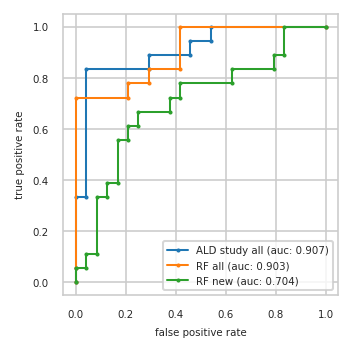

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.333  0.000 0.722  0.042 0.056
3          0.042 0.333  0.208 0.722  0.042 0.111
4          0.042 0.833  0.208 0.778  0.083 0.111
5          0.292 0.833  0.292 0.778  0.083 0.333
6          0.292 0.889  0.292 0.833  0.125 0.333
7          0.458 0.889  0.417 0.833  0.125 0.389
8          0.458 0.944  0.417 1.000  0.167 0.389
9          0.542 0.944  1.000 1.000  0.167 0.556
10         0.542 1.000    NaN   NaN  0.208 0.556
11         1.000 1.000    NaN   NaN  0.208 0.611
12           NaN   NaN    NaN   NaN  0.250 0.611
13           NaN   NaN    NaN   NaN  0.250 0.667
14           NaN   NaN    NaN   NaN  0.375 0.667
15           NaN   NaN    NaN   NaN  0.375 0.722
16           NaN   NaN    NaN   NaN  0.417 0.722
17           NaN   NaN    NaN   NaN  0.417 0.778
18           NaN   NaN    NaN   NaN  0.625 0.778
19           NaN   NaN    NaN   NaN  0.625 0.833
20           NaN   NaN    NaN   NaN  0.792 0.833
21           NaN   NaN    NaN   NaN  0.792 0.889
22           NaN   NaN    NaN   NaN  0.833 0.889
23           NaN   NaN    NaN   NaN  0.833 1.000
24           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P0DJI8,P26572,E5RK69;E7EMC6;P08133;P08133-2
2,P01258;P01258-2;P06881,A0A1B0GV23;A0A1B0GVD5;A0A1B0GWE8;P07339,P42262;P42262-2;P42262-3
3,Q13231;Q13231-3,Q9Y2T3;Q9Y2T3-3,P51688
4,Q9Y2T3;Q9Y2T3-3,P04075,P31321
5,P00338;P00338-3,P14174,J3KSJ8;Q9UD71;Q9UD71-2
6,P04075,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P14174,Q14894,Q9NUQ9
8,P61981,P63104,Q96GD0


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


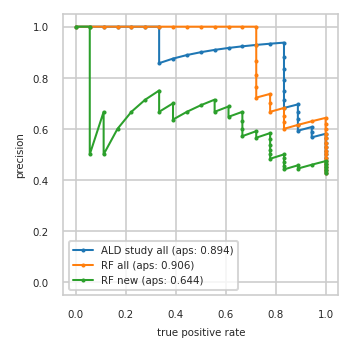

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.621 1.000     0.483 0.778
14         0.607 0.944     0.643 1.000     0.500 0.778
15         0.593 0.889     0.630 0.944     0.519 0.778
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.600 0.833     0.560 0.778
18         0.667 0.889     0.625 0.833     0.583 0.778
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.714 0.833     0.667 0.778     0.571 0.667
22         0.750 0.833     0.700 0.778     0.600 0.667
23         0.789 0.833     0.737 0.778     0.632 0.667
24         0.833 0.833     0.722 0.722     0.667 0.667
25         0.882 0.833     0.765 0.722     0.647 0.611
26         0.938 0.833     0.812 0.722     0.688 0.611
27         0.933 0.778     0.867 0.722     0.667 0.556
28         0.929 0.722     0.929 0.722     0.714 0.556
29         0.923 0.667     1.000 0.722     0.692 0.500
30         0.917 0.611     1.000 0.667     0.667 0.444
31         0.909 0.556     1.000 0.611     0.636 0.389
32         0.900 0.500     1.000 0.556     0.700 0.389
33         0.889 0.444     1.000 0.500     0.667 0.333
34         0.875 0.389     1.000 0.444     0.750 0.333
35         0.857 0.333     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


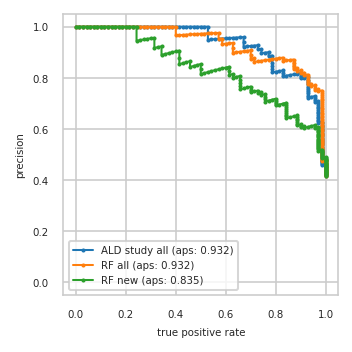

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


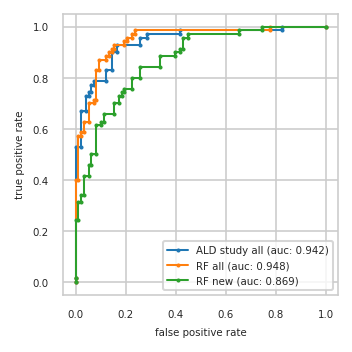

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}